In [6]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

import bezier

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# make page
paper_size = '11x14 inches'
border:float=20
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [193]:
lines = []

node_sets = []
n_lines = 1200
n_nodes_per_line = 20
y_start = 1
y_end = 10
x_start = 1
x_end = 10
node_x_centers = np.linspace(x_start, x_end, n_lines)
std_scale = 0.02
n_eval_points = 250

### initialize vals
node_ys = np.linspace(y_start, y_end, n_nodes_per_line)
centered_node_xs = np.zeros(node_ys.shape)
bez_eval_end_center = 1
bez_eval_end_noise = 0
bez_eval_end_limit = 1.1
bez_eval_end_std_scale = 0.01

for i, node_x_center in enumerate(node_x_centers):
#     node_ys = np.flipud(node_ys)
#     centered_node_xs = np.flipud(centered_node_xs)
    new_x_noise = np.random.randn(n_nodes_per_line) * std_scale
#     bez_eval_end_noise = bez_eval_end_noise + np.random.randn() * bez_eval_end_std_scale
    centered_node_xs = centered_node_xs + new_x_noise
    node_xs = node_x_center + centered_node_xs
    node_xs[0:3] = node_x_center
#     node_xs[-1] = node_x_center
    nodes = np.asfortranarray([
        node_xs,
        node_ys,
        ])
    curve = bezier.Curve(nodes, degree=(nodes.shape[1]-1))
#     bez_eval_end = bez_eval_end_center + bez_eval_end_noise
#     if bez_eval_end > bez_eval_end_limit:
#         bez_eval_end = 1 + np.random.randn()*0.02
#     eval_points = np.linspace(0, bez_eval_end, n_eval_points)
    eval_points = np.linspace(0, 1, n_eval_points)
    x, y = curve.evaluate_multi(eval_points)
    if i % 2:
        x = np.flipud(x)
        y = np.flipud(y)
    lines.append(np.stack([x, y]).T)
    node_sets.append(np.stack([node_xs, node_ys]).T)

In [194]:
ls = [LineString(l) for l in lines]

In [195]:
mls = gp.make_like(gp.merge_LineStrings(ls), drawbox)

In [196]:
mask = drawbox.centroid.buffer(100)

In [197]:
in_mask = mls.intersection(mask)

In [198]:
in_mask = sa.rotate(in_mask, -90)

In [199]:
split_point = 2100

In [200]:
layer1 = in_mask[:2100]
layer2 = in_mask[2100:]

In [201]:
layers = []
layers.append(LineString(np.concatenate([np.array(l) for l in layer1])))
layers.append(LineString(np.concatenate([np.array(l) for l in layer2])))

In [206]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# sk.vpype(f'linesimplify --tolerance 0.3mm')

sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-08T17:55:40.583180 
 
 
 
 
 
 <polyline points="574.1025,1047.005 571.0111,1047.1731 567.57,1047.358 564.129,1047.5404 560.6879,1047.7199 558.4873,1047.8327 558.4873,1047.8327 557.2469,1047.8963 553.8058,1048.0693 550.3648,1048.2387 546.9237,1048.4043 543.4826,1048.5661 540.0416,1048.7238 536.6005,1048.8773 533.1595,1049.0267 529.7184,1049.1718 526.2774,1049.3127 522.8363,1049.4494 519.3953,1049.582 517.4968,1049.6528 517.896,1049.6724 519.3953,1049.6159 522.8363,1049.4819 526.2774,1049.3435 529.7184,1049.2007 533.1595,1049.0533 536.6005,1048.9015 540.0416,1048.7451 543.4826,1048.5842 546.9237,1048.419 550.3648,1048.2495 553.8058,1048.0758 557.2469,1047.8981 558.4873,1047.8327 558.4873,1047.8327 560.6879,1047.7166 564.129,1047.5316 567.57,1047.3434 571.0111,1047.1521 574.3971,1046.9613 590.8157,1044.5259 588.2163,1044.6798 584.7753,1044.8834 581.3342,1045.0862 577.8932,1045.2878 574.4521,1045.4877 571.0111,1045.6856 567.57,1045.8811 564.129,1046.0738 560.6879,1046.2633 557.2469,1046.4494 553.8058,1046.6319 550.3648,1046.8105 546.9237,1046.985 543.4826,1047.1552 540.0416,1047.3211 537.5012,1047.4402 537.5012,1047.4402 536.6005,1047.4825 533.1595,1047.6394 529.7184,1047.7917 526.2774,1047.9395 522.8363,1048.0827 519.3953,1048.2215 515.9542,1048.3559 512.5132,1048.4861 509.0721,1048.6122 505.6311,1048.7343 502.19,1048.8527 501.6067,1048.8722 503.0557,1048.9434 505.6311,1048.8477 509.0721,1048.7157 512.5132,1048.5792 515.9542,1048.4381 519.3953,1048.2922 522.8363,1048.1413 526.2774,1047.9854 529.7184,1047.8243 533.1595,1047.658 536.6005,1047.4865 537.5012,1047.4402 537.5012,1047.4402 540.0416,1047.3098 543.4826,1047.1279 546.9237,1046.9409 550.3648,1046.749 553.8058,1046.5522 557.2469,1046.3508 560.6879,1046.1449 564.129,1045.9348 567.57,1045.7209 571.0111,1045.5033 574.4521,1045.2826 577.8932,1045.0589 581.3342,1044.8329 584.7753,1044.6048 588.2163,1044.3753 591.6574,1044.1447 594.8148,1043.9327 599.9403,1043.1724 598.5395,1043.2629 595.0984,1043.4847 591.6574,1043.7051 588.2163,1043.9237 584.7753,1044.14 581.3342,1044.3536 577.8932,1044.564 574.4521,1044.7709 571.0111,1044.9739 567.57,1045.1727 564.129,1045.367 560.6879,1045.5566 557.2469,1045.7412 553.8058,1045.9208 550.3648,1046.0952 546.9237,1046.2642 543.4826,1046.4279 540.0416,1046.5863 536.6005,1046.7393 533.1595,1046.8869 529.7184,1047.0294 526.2774,1047.1668 522.8363,1047.2992 519.3953,1047.4269 515.9542,1047.55 512.5132,1047.6689 509.0721,1047.7837 505.6311,1047.8947 502.19,1048.0023 498.749,1048.1067 495.3079,1048.2084 491.8669,1048.3076 490.8652,1048.3359 487.7716,1047.877 488.4258,1047.8587 491.8669,1047.7599 495.3079,1047.6578 498.749,1047.5522 502.19,1047.4426 505.6311,1047.3286 509.0721,1047.2101 512.5132,1047.0866 515.9542,1046.9578 519.3953,1046.8236 522.8363,1046.6838 526.2774,1046.538 529.7184,1046.3862 533.1595,1046.2282 536.6005,1046.064 540.0416,1045.8935 543.4826,1045.7166 546.9237,1045.5334 550.3648,1045.344 553.8058,1045.1484 557.2469,1044.9467 560.6879,1044.7393 564.129,1044.5262 567.57,1044.3077 571.0111,1044.0842 574.4521,1043.8559 577.8932,1043.6233 581.3342,1043.3868 584.7753,1043.1467 588.2163,1042.9036 591.6574,1042.658 595.0984,1042.4105 598.5395,1042.1616 601.9805,1041.9119 605.4216,1041.6621 607.2212,1041.5317 615.4855,1039.4616 612.3037,1039.696 608.8626,1039.9512 605.4216,1040.2072 601.9805,1040.4635 598.5395,1040.7193 595.0984,1040.9741 591.6574,1041.2273 588.2163,1041.4782 584.7753,1041.7263 581.3342,1041.9711 577.8932,1042.212 574.4521,1042.4487 571.0111,1042.6807 567.57,1042.9077 564.129,1043.1292 560.6879,1043.3449 557.2469,1043.5547 553.8058,1043.7583 550.3648,1043.9555 546.9237,1044.146 543.4826,1044.33 540.0416,1044.5072 536.6005,1044.6776 533.1595,1044.8413 529.7184,1044.9983 526.2774,1045.1487 522.8363,1045.2926 519.3953,1045.4302 515.9542,1045.5617 512.5132,1045.6872 509.0721,1045.8071 505.6311,1045.9217 502.19,1046.0311 498.749,1046.1359 495.3079,1046.2363

In [203]:
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/169_all_curve.svg')

# lets get more spacing, to work better with staedtlers

In [211]:
# make page
paper_size = '11x14 inches'
border:float=20
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [214]:
lines = []

node_sets = []
n_lines = 800
n_nodes_per_line = 20
y_start = 1
y_end = 10
x_start = 1
x_end = 10
node_x_centers = np.linspace(x_start, x_end, n_lines)
std_scale = 0.025
n_eval_points = 250

### initialize vals
node_ys = np.linspace(y_start, y_end, n_nodes_per_line)
centered_node_xs = np.zeros(node_ys.shape)
bez_eval_end_center = 1
bez_eval_end_noise = 0
bez_eval_end_limit = 1.1
bez_eval_end_std_scale = 0.01

for i, node_x_center in enumerate(node_x_centers):
#     node_ys = np.flipud(node_ys)
#     centered_node_xs = np.flipud(centered_node_xs)
    new_x_noise = np.random.randn(n_nodes_per_line) * std_scale
#     bez_eval_end_noise = bez_eval_end_noise + np.random.randn() * bez_eval_end_std_scale
    centered_node_xs = centered_node_xs + new_x_noise
    node_xs = node_x_center + centered_node_xs
    node_xs[0:3] = node_x_center
#     node_xs[-1] = node_x_center
    nodes = np.asfortranarray([
        node_xs,
        node_ys,
        ])
    curve = bezier.Curve(nodes, degree=(nodes.shape[1]-1))
#     bez_eval_end = bez_eval_end_center + bez_eval_end_noise
#     if bez_eval_end > bez_eval_end_limit:
#         bez_eval_end = 1 + np.random.randn()*0.02
#     eval_points = np.linspace(0, bez_eval_end, n_eval_points)
    eval_points = np.linspace(0, 1, n_eval_points)
    x, y = curve.evaluate_multi(eval_points)
    if i % 2:
        x = np.flipud(x)
        y = np.flipud(y)
    lines.append(np.stack([x, y]).T)
    node_sets.append(np.stack([node_xs, node_ys]).T)

In [215]:
ls = [LineString(l) for l in lines]

mls = gp.make_like(gp.merge_LineStrings(ls), drawbox)

mask = drawbox.centroid.buffer(100)

in_mask = mls.intersection(mask)

in_mask = sa.rotate(in_mask, -90)

3156

In [225]:
inds = np.arange(len(in_mask))

split_inds = np.array_split(inds[200:], 4)

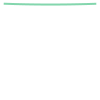

In [230]:
in_mask.geoms[0]

In [231]:

layers = []
for ind in split_inds:
    layer = [in_mask[i] for i in ind]
    layers.append(LineString(np.concatenate([np.array(l) for l in layer])))

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# sk.vpype(f'linesimplify --tolerance 0.3mm')

sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-08T21:24:48.604468 
 
 
 
 
 
 <polyline points="649.5228,1023.1819 648.2978,1023.1621 645.0021,1023.1044 641.7064,1023.0427 638.4106,1022.9774 636.9967,1022.9481 636.9967,1022.9481 635.1149,1022.9091 632.6224,1022.8554 632.6224,1022.8554 631.8192,1022.8381 628.5235,1022.7648 627.4678,1022.7407 627.4678,1022.7407 625.2277,1022.6897 621.932,1022.6132 618.6363,1022.5356 615.3406,1022.4573 612.0448,1022.3787 608.7491,1022.3 605.7531,1022.2289 605.7531,1022.2289 605.4534,1022.2217 602.1577,1022.1441 598.8619,1022.0674 595.5662,1021.9919 592.2705,1021.9179 588.9748,1021.8457 585.679,1021.7756 582.3833,1021.7077 579.0876,1021.6424 575.7919,1021.5798 572.4961,1021.5202 569.2004,1021.4638 565.9047,1021.4107 562.609,1021.3613 561.2317,1021.3422 561.2317,1021.3422 559.3132,1021.3156 556.0175,1021.2739 553.0309,1021.2398 553.0309,1021.2398 552.7218,1021.2363 549.4261,1021.2029 546.1303,1021.174 542.8346,1021.1497 539.5389,1021.1301 536.2432,1021.1153 532.9474,1021.1054 529.6517,1021.1006 526.356,1021.1009 523.0603,1021.1065 519.7645,1021.1173 517.8333,1021.1268 517.8333,1021.1268 516.4688,1021.1335 513.1731,1021.155 509.8774,1021.182 506.5816,1021.2143 503.2859,1021.2521 499.9902,1021.2953 496.6945,1021.3437 496.069,1021.3539 496.069,1021.3539 493.3987,1021.3975 490.103,1021.4564 486.8073,1021.5204 483.5116,1021.5894 480.2158,1021.6632 476.9201,1021.7417 473.6244,1021.8247 470.3287,1021.9119 467.0329,1022.0031 463.7372,1022.0981 460.4415,1022.1967 457.1458,1022.2984 453.85,1022.403 450.5543,1022.5102 447.2586,1022.6195 443.9629,1022.7307 440.6671,1022.8432 437.3714,1022.9568 434.0757,1023.0709 430.78,1023.1851 427.4842,1023.2989 424.1885,1023.4119 420.8928,1023.5236 417.5971,1023.6335 414.3013,1023.741 411.0056,1023.8458 407.7099,1023.9472 404.4142,1024.0448 402.3584,1024.103 402.3584,1024.103 401.1184,1024.1381 397.8227,1024.2265 394.527,1024.3096 391.2313,1024.3869 387.9355,1024.458 384.6398,1024.5223 381.3441,1024.5795 378.0484,1024.6292 374.7526,1024.6709 371.4569,1024.7043 368.1612,1024.7291 364.8655,1024.745 361.5697,1024.7518 358.274,1024.7492 354.9783,1024.737 351.6826,1024.7151 348.3868,1024.6834 345.0911,1024.6418 341.7954,1024.5904 340.7518,1024.5711 338.6844,1023.3319 341.7954,1023.3583 345.0911,1023.3765 348.3868,1023.3851 351.6826,1023.3839 354.9783,1023.3733 358.274,1023.3533 361.5697,1023.3241 364.8655,1023.286 368.1612,1023.2392 371.4569,1023.1841 374.7526,1023.1209 378.0484,1023.0501 381.3441,1022.9719 384.6398,1022.887 387.9355,1022.7956 391.2313,1022.6983 394.527,1022.5955 397.8227,1022.4877 401.1184,1022.3754 404.4142,1022.2591 407.7099,1022.1394 411.0056,1022.0167 414.3013,1021.8915 417.5971,1021.7644 420.8928,1021.6359 424.1885,1021.5065 427.4842,1021.3767 430.78,1021.2469 434.0757,1021.1177 437.3714,1020.9894 440.6671,1020.8626 443.9629,1020.7377 447.2586,1020.615 450.5543,1020.495 453.85,1020.378 457.1458,1020.2644 460.4415,1020.1545 463.7372,1020.0486 467.0329,1019.9469 470.3287,1019.8499 473.6244,1019.7575 476.9201,1019.6702 480.2158,1019.588 483.5116,1019.5112 486.8073,1019.4399 490.103,1019.3741 493.3987,1019.3141 496.6945,1019.2598 499.9902,1019.2114 503.2859,1019.1689 506.5816,1019.1323 509.8774,1019.1016 513.1731,1019.0768 516.4688,1019.0579 519.7645,1019.0448 523.0603,1019.0376 526.356,1019.036 529.6517,1019.0401 532.9474,1019.0497 536.2432,1019.0648 539.5389,1019.0852 542.8346,1019.1108 546.1303,1019.1415 549.4261,1019.1772 552.7218,1019.2177 556.0175,1019.2628 559.3132,1019.3125 562.609,1019.3665 565.9047,1019.4246 569.2004,1019.4868 572.4961,1019.5528 575.7919,1019.6225 579.0876,1019.6956 582.3833,1019.7719 585.679,1019.8513 588.9748,1019.9335 592.2705,1020.0183 595.5662,1020.1055 598.8619,1020.1948 602.1577,1020.286 605.4534,1020.3788 608.7491,1020.473 612.0448,1020.5683 615.3406,1020.6643 618.6363,1020.7609 621.932,1020.8576 625.2277,1020.9542 628.5235,1021.0503 631.8192,1021.1454 635.1149,1021.2394 638.4106,1021.3317 641.7064

In [232]:
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/171_all_curve.svg')